<a href="https://colab.research.google.com/github/MicroPyscho/Credit-Card-Fraud-Prediction-using-GAN/blob/main/Credit_Card_FraudGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gan
!pip install matplotlib seaborn
!pip install ssgan
!pip install pyarrow
#!pip install tabgan

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
#from ssgan.ssgan import SemiSupervisedGAN
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 8.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement ssgan (from versions: none)
ERROR: No matching distribution found for ssgan


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/df_train.csv'
df_train_contd = pd.read_csv(file_path)

In [4]:
df_train_contd.head()

,Unnamed: 0,cc_num,category,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,tx_time,age
0,0,2703186189652095,misc_net,4.97,F,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,00:00:18,36
1,1,630423337322,grocery_pos,107.23,F,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,00:00:44,45
2,2,38859492057661,entertainment,220.11,M,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,00:00:51,62
3,3,3534093764340240,gas_transport,45.00,M,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,00:01:16,57
4,4,375534208663984,misc_pos,41.96,M,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,00:03:06,37


Create a sample of dataset

In [5]:
df_train_contd.reset_index(drop=True, inplace=True)

minor_class = df_train_contd[df_train_contd['is_fraud'] == 1]
major_class = df_train_contd[df_train_contd['is_fraud'] == 0]

num_minority = minor_class.shape[0]
num_majority = major_class.shape[0]

minor_sample_prop = 0.7

num_minor_samples = min(int(50000 * minor_sample_prop), num_minority)
num_major_samples = 50000 - num_minor_samples

# Sample from each class separately
minor_samp = minor_class.sample(n=num_minor_samples, random_state=42, replace=num_minor_samples > num_minority)
major_samp = major_class.sample(n=num_major_samples, random_state=42, replace=num_major_samples > num_majority)

# Concatenate the samples
df_train_contd_eg = pd.concat([minor_samp, major_samp], ignore_index=True)

print("Sampled dataset info:")
print(df_train_contd_eg.info())


Sampled dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50000 non-null  int64  
 1   cc_num      50000 non-null  int64  
 2   category    50000 non-null  object 
 3   amt         50000 non-null  float64
 4   gender      50000 non-null  object 
 5   zip         50000 non-null  int64  
 6   lat         50000 non-null  float64
 7   long        50000 non-null  float64
 8   city_pop    50000 non-null  int64  
 9   merch_lat   50000 non-null  float64
 10  merch_long  50000 non-null  float64
 11  is_fraud    50000 non-null  int64  
 12  tx_time     50000 non-null  object 
 13  age         50000 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 5.3+ MB
None


<Figure size 1200x800 with 0 Axes>

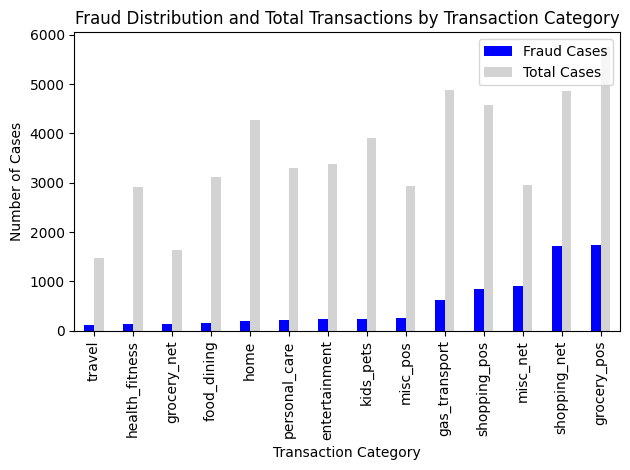

In [6]:
# Group by category and count fraud cases in each category
fraud_by_category = df_train_contd_eg.groupby("category")["is_fraud"].agg(fraud_cases='sum', total_cases='count').sort_values(by="fraud_cases")

# Plot the graph
plt.figure(figsize=(12, 8))
fraud_by_category.plot(kind='bar', color=['blue', 'lightgrey'])
plt.xlabel("Transaction Category")
plt.ylabel("Number of Cases")
plt.title("Fraud Distribution and Total Transactions by Transaction Category")
plt.legend(["Fraud Cases", "Total Cases"], loc="upper right")
plt.tight_layout()
plt.show()


In [7]:
df_train_contd_eg.head()

,Unnamed: 0,cc_num,category,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,tx_time,age
0,758837,4365382885912355,grocery_pos,312.51,M,55771,48.1439,-92.8561,1680,48.488032,-92.519786,1,22:18:56,47
1,981412,180048185037117,kids_pets,20.53,F,7060,40.6152,-74.4150,71485,40.151652,-75.278513,1,23:13:33,49
2,799445,4102003771126577611,grocery_pos,264.10,M,76248,32.9276,-97.2489,95035,33.098306,-97.968694,1,01:53:21,36
3,112813,2657850734909997,shopping_net,987.73,M,48206,42.3749,-83.1087,673342,42.814546,-82.624587,1,22:11:30,77
4,833901,3557442674264531,shopping_net,868.00,F,43136,39.8013,-82.8125,460,38.819028,-82.364296,1,22:37:25,19


In [8]:
#check for missing values
missing_values = df_train_contd_eg.isna().sum()

df_train_contd = df_train_contd_eg.reset_index(drop=True)
print("missing values per column:")
print (missing_values)

missing values per column:
Unnamed: 0    0
cc_num        0
category      0
amt           0
gender        0
zip           0
lat           0
long          0
city_pop      0
merch_lat     0
merch_long    0
is_fraud      0
tx_time       0
age           0
dtype: int64


Drop all problematic columns

---



In [9]:
#drop problematic columns
real_dataset = df_train_contd.drop(columns=["Unnamed: 0", "cc_num", "category"])
print(real_dataset.shape)

(50000, 11)


Scale and Transform the dataset

In [10]:
#Scale, one hot encode and transform data
cat_features = ["gender"]
cat_transformer = OneHotEncoder()

num_features = ["amt", "zip", "lat", "long", "city_pop", "merch_lat", "merch_long", "age"]
num_transformer =StandardScaler()

preprocessor =ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", num_transformer, num_features)
    ]
)

cat_encoded = cat_transformer.fit_transform(real_dataset[cat_features])


z_encoded = hstack([cat_encoded, real_dataset[num_features].values])

encoded_cat_feat = cat_transformer.get_feature_names_out(input_features=cat_features)

#encoded_cat_feat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = list(encoded_cat_feat) + num_features

print("Original Dataframe shape:", real_dataset.shape)
print("Encoded DataFrame shape:", z_encoded.shape)
print("feature_names length:", len(feature_names))
print("z_encoded shape:", z_encoded.shape[1])
print("First few rows of z_encoded:")

encoded_df = pd.DataFrame(data=z_encoded.toarray(), columns=feature_names)

df_train_encoded = pd.concat([real_dataset.drop(columns=cat_features + num_features), encoded_df], axis=1)
print("Original Dataframe shape:", real_dataset.shape)
print("Encoded DataFrame shape:", df_train_encoded.shape)

df_train_encoded.reset_index(drop=True, inplace=True)
df_train_contd = df_train_encoded
df_train_contd.head()

Original Dataframe shape: (50000, 11)
Encoded DataFrame shape: (50000, 10)
feature_names length: 10
z_encoded shape: 10
First few rows of z_encoded:
Original Dataframe shape: (50000, 11)
Encoded DataFrame shape: (50000, 12)


,is_fraud,tx_time,gender_F,gender_M,amt,zip,lat,long,city_pop,merch_lat,merch_long,age
0,1,22:18:56,0.0,1.0,312.51,55771.0,48.1439,-92.8561,1680.0,48.488032,-92.519786,47.0
1,1,23:13:33,1.0,0.0,20.53,7060.0,40.6152,-74.4150,71485.0,40.151652,-75.278513,49.0
2,1,01:53:21,0.0,1.0,264.10,76248.0,32.9276,-97.2489,95035.0,33.098306,-97.968694,36.0
3,1,22:11:30,0.0,1.0,987.73,48206.0,42.3749,-83.1087,673342.0,42.814546,-82.624587,77.0
4,1,22:37:25,1.0,0.0,868.00,43136.0,39.8013,-82.8125,460.0,38.819028,-82.364296,19.0


Scale Data using StandardScaler and RandomForestClassifier

In [11]:
real_dataset = real_dataset

#Load data into chunks and preprocess in chunks due to size
num_chunks = 10

#Feature importance containers
num_feats = real_dataset.shape[1]-1
rf_feature_importance = np.zeros(num_feats)
lasso_feature_coefficients = np.zeros(num_feats)

#separate target from class columns
X = real_dataset.drop(columns=["is_fraud"])
y = real_dataset["is_fraud"]

scaler = StandardScaler()

for i in range(num_chunks):
  chunk_size = len(real_dataset)//num_chunks
  start_idx = i * chunk_size
  end_idx = start_idx + chunk_size
  start_idx = start_idx + chunk_size
  chunk_x = X.iloc[start_idx:end_idx]
  chunk_y = y.iloc[start_idx:end_idx]

  if len(chunk_x) > 0:
    x_chunk_scaled = scaler.fit_transform(chunk_x) #Random Forest Feature Importance
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(x_chunk_scaled, chunk_y)
    rf_feature_importance += rf_model.feature_importances_

    lasso_model = Lasso(alpha=0.1, random_state=42)  #Lasso Regression Feature Importance
    lasso_model.fit(x_chunk_scaled, chunk_y)
    lasso_feature_coefficients += lasso_model.coef_

rf_feature_importance /= num_chunks
lasso_feature_coefficients /= num_chunks




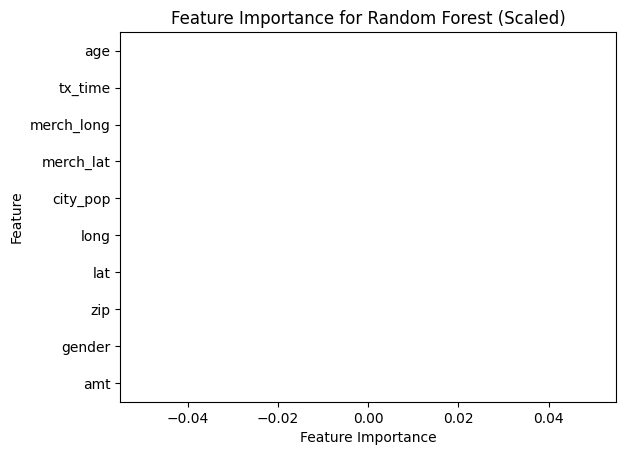

Feature Names: 10
Coefficients: 10
Length of feature importances array: 10
Feature Names: ['amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'tx_time', 'age']
Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Length of feature_nms: 10
Length of lasso_feature_coefficients: 10


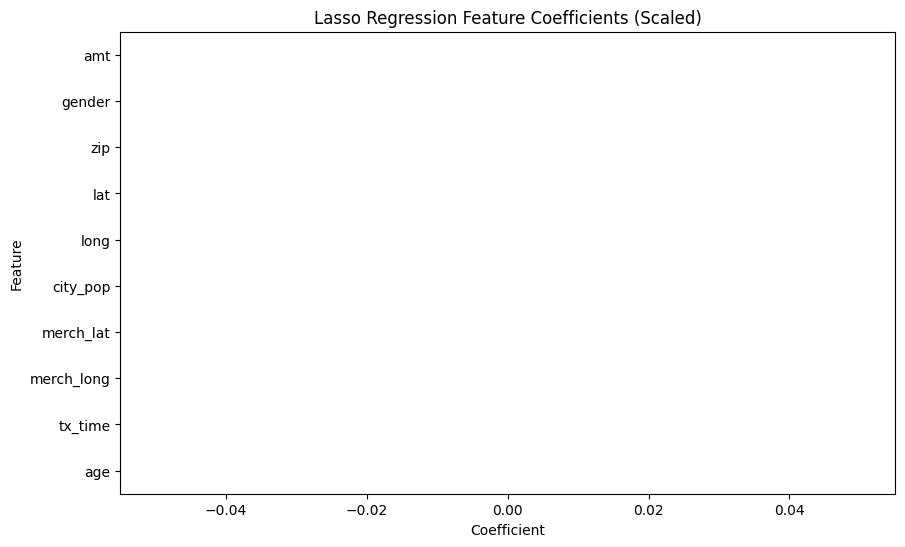

In [12]:
def plot_feature_importances(rf_feature_importance, feature_nms, title):
  sorted_idx = rf_feature_importance.argsort()[::-1]
  top_10 = sorted_idx[:10]
  sns.barplot(x=rf_feature_importance[top_10], y=pd.Series(feature_nms)[top_10])
  plt.xlabel("Feature Importance")
  plt.ylabel("Feature")
  plt.title(title)
  plt.show()

def plot_coefficients(lasso_feature_coefficients, feature_nms, title):
    #assert len(feature_nms)==len(lasso_feature_coefficients),"Lengths of feature importance must match"

    print("Length of feature_nms:", len(X.columns.tolist()))
    print("Length of lasso_feature_coefficients:", len(lasso_feature_coefficients))

    coef_df = pd.DataFrame({"Feature": feature_nms,"Coefficient": lasso_feature_coefficients})
    coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
    top_10_co =coef_df.head(10)
    plt.figure(figsize =(10, 6))
    sns.barplot(x="Coefficient", y = "Feature", data=top_10_co)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.title(title)
    plt.show()

feature_importances_scaled = scaler.fit_transform(rf_feature_importance.reshape(-1, 1))
coefficients_scaled = scaler.fit_transform(lasso_feature_coefficients.reshape(-1, 1))

feature_nms = X.columns.tolist()
plot_feature_importances(rf_feature_importance, feature_nms, "Feature Importance for Random Forest (Scaled)")

feature_nms = X.columns.tolist()

print("Feature Names:", len(feature_nms))
print("Coefficients:", len(lasso_feature_coefficients))

feature_importances_length = len(rf_feature_importance)
print("Length of feature importances array:", feature_importances_length)

print("Feature Names:", feature_nms)
print("Coefficients:", lasso_feature_coefficients)

plot_coefficients(lasso_feature_coefficients, feature_nms, "Lasso Regression Feature Coefficients (Scaled)")


In [13]:
real_data = df_train_contd.select_dtypes(include={"number"})
print(real_data.shape)
real_data.head()

(50000, 11)


,is_fraud,gender_F,gender_M,amt,zip,lat,long,city_pop,merch_lat,merch_long,age
0,1,0.0,1.0,312.51,55771.0,48.1439,-92.8561,1680.0,48.488032,-92.519786,47.0
1,1,1.0,0.0,20.53,7060.0,40.6152,-74.4150,71485.0,40.151652,-75.278513,49.0
2,1,0.0,1.0,264.10,76248.0,32.9276,-97.2489,95035.0,33.098306,-97.968694,36.0
3,1,0.0,1.0,987.73,48206.0,42.3749,-83.1087,673342.0,42.814546,-82.624587,77.0
4,1,1.0,0.0,868.00,43136.0,39.8013,-82.8125,460.0,38.819028,-82.364296,19.0


##Balance the data using SMOTE

In [14]:
#Separate features and target variable
real_data = df_train_contd.select_dtypes(include={"number"})


X = real_data.drop(columns=['is_fraud'])
y = real_data['is_fraud']

#Apply SMOTE to generate synthetic samples
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)

#Combine original and synthetic samples
balanced_data = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='is_fraud')], axis=1)

#Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

#Print balanced dataset shape
print(balanced_data.shape)
print(balanced_data.head())


(84988, 11)
   gender_F  gender_M     amt      zip      lat     long  city_pop  merch_lat  \
0       0.0       1.0  312.51  55771.0  48.1439 -92.8561    1680.0  48.488032   
1       1.0       0.0   20.53   7060.0  40.6152 -74.4150   71485.0  40.151652   
2       0.0       1.0  264.10  76248.0  32.9276 -97.2489   95035.0  33.098306   
3       0.0       1.0  987.73  48206.0  42.3749 -83.1087  673342.0  42.814546   
4       1.0       0.0  868.00  43136.0  39.8013 -82.8125     460.0  38.819028   

   merch_long   age  is_fraud  
0  -92.519786  47.0         1  
1  -75.278513  49.0         1  
2  -97.968694  36.0         1  
3  -82.624587  77.0         1  
4  -82.364296  19.0         1  


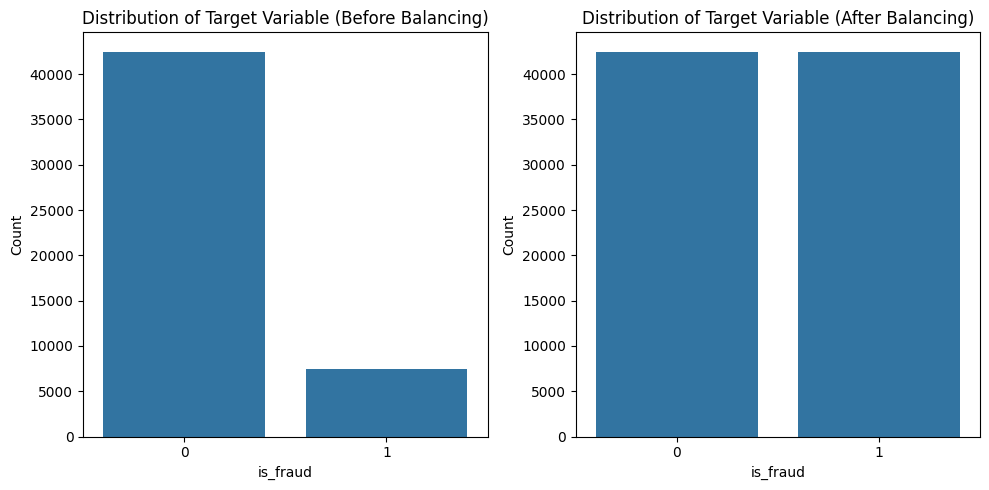

In [15]:
# Before balancing
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='is_fraud', data=real_data)
plt.title('Distribution of Target Variable (Before Balancing)')
plt.xlabel('is_fraud')
plt.ylabel('Count')

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x='is_fraud', data=balanced_data)
plt.title('Distribution of Target Variable (After Balancing)')
plt.xlabel('is_fraud')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


##Predicting F1, Accuracy, Recall and Precision on SMOTE balanced data


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


X = balanced_data.drop('is_fraud', axis=1)
y = balanced_data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = LinearSVC(C=0.1, random_state=42)  # Linear kernel often faster
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.751970820096482
Precision: 0.970989010989011
Recall: 0.5196424370736298
F1 Score: 0.676984370211462

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80      8496
           1       0.97      0.52      0.68      8502

    accuracy                           0.75     16998
   macro avg       0.82      0.75      0.74     16998
weighted avg       0.82      0.75      0.74     16998



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


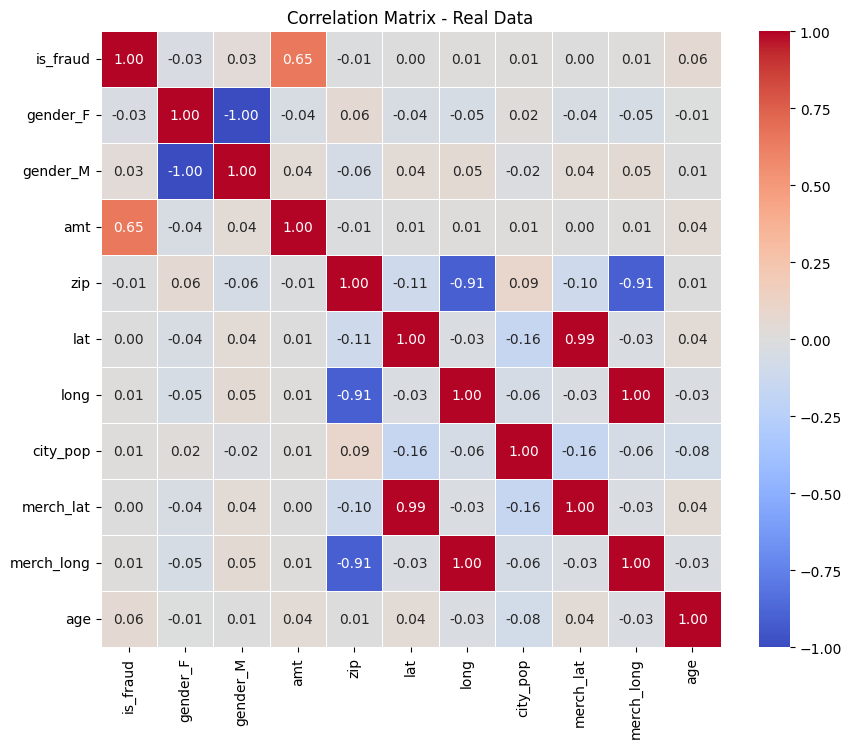

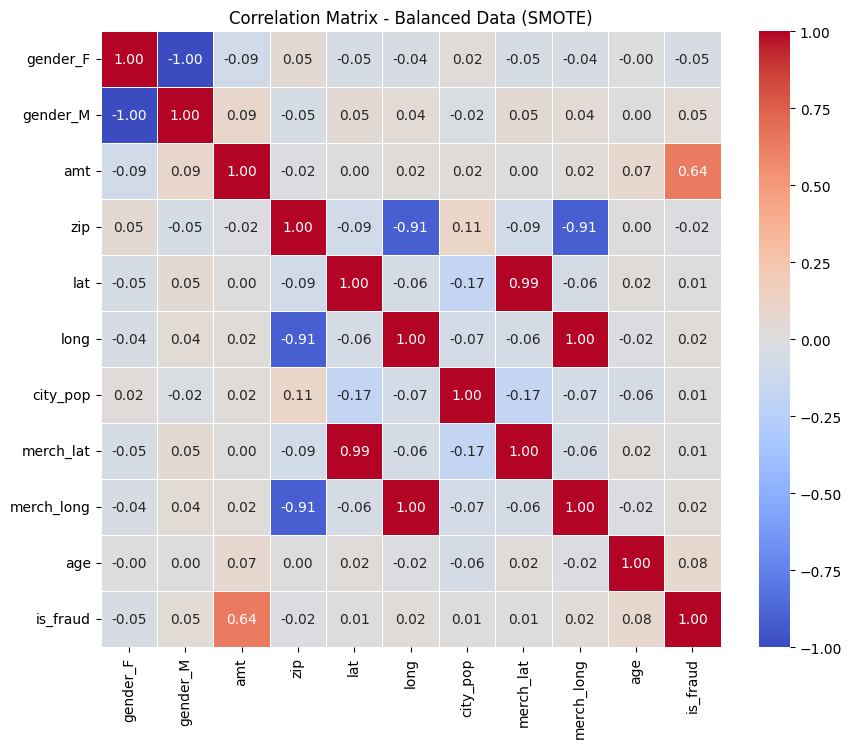

In [16]:
corr_real = real_data.corr()

corr_balanced = balanced_data.corr()

# Plot correlation matrix for real data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_real, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - Real Data')
plt.show()

# Plot correlation matrix for balanced data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_balanced, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - Balanced Data (SMOTE)')
plt.show()


##Definition of GAN Parameters

In [17]:
print(real_data.shape)

(50000, 11)


In [18]:
real_data.columns

Index(['is_fraud', 'gender_F', 'gender_M', 'amt', 'zip', 'lat', 'long',
       'city_pop', 'merch_lat', 'merch_long', 'age'],
      dtype='object')

In [19]:
from random import shuffle

class Gan():
    def __init__(self, real_data, latent_dim):
        self.real_data = real_data
        self.latent_dim = latent_dim
        self.n_epochs = 64

    def _noise(self, batch_size):
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(5000, activation='relu', input_shape=(self.latent_dim,),
                                         kernel_initializer='he_uniform'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dense(1000, activation='relu'))
        model.add(tf.keras.layers.Dense(self.real_data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(5000, input_shape=(self.real_data.shape[1],),
                                         kernel_initializer='he_uniform'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dense(2500))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    def train(self, generator, discriminator, gan, batch_size=128):
        for epoch in range(1, self.n_epochs + 1):
           minority_samples = self.real_data[self.real_data['is_fraud'] == 1]
           minority_indices = np.random.randint(0, minority_samples.shape[0], size=batch_size)
           minority_batch = minority_samples.iloc[minority_indices]

           majority_samples = self.real_data[self.real_data['is_fraud'] == 0]
           majority_indices = np.random.randint(0, majority_samples.shape[0], size=batch_size)
           majority_batch = majority_samples.iloc[majority_indices]

           X = pd.concat([minority_batch, majority_batch])
           X = X.sample(frac=1)

           y_discriminator = np.zeros(2 * batch_size)
           y_discriminator[:batch_size] = 1

           discriminator.train_on_batch(X, y_discriminator)

           noise = self._noise(batch_size)
           y_generator = np.ones(batch_size)
           gan.train_on_batch(noise, y_generator)



            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            #fake_samples = generator.predict(noise)
            #y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            #X = np.concatenate([self.real_data.sample(batch_size), fake_samples])
            #discriminator.trainable = True
            #discriminator.train_on_batch(X, y)
            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            #y_gen = np.ones((batch_size, 1))
            #discriminator.trainable = False
            #gan.train_on_batch(noise, y_gen)
           if epoch % 10 == 0:
            print(f"Epoch {epoch}/{self.n_epochs}")

        return generator


In [28]:
real_data = real_data
latent_dim = 500

gan_instance = Gan(real_data, latent_dim)

generator = gan_instance._generator()
discriminator = gan_instance._discriminator()

gan = gan_instance._GAN(generator, discriminator)

trained_generator = gan_instance.train(generator, discriminator, gan)

num_synthetic_samples = 50000
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))
synthetic_data = trained_generator.predict(noise)

synthetic_data_df = pd.DataFrame(synthetic_data, columns=real_data.columns)
synthetic_data_df.columns = synthetic_data_df.columns = ['is_fraud', 'gender_F', 'gender_M', 'amt', 'zip', 'lat', 'long',
       'city_pop', 'merch_lat', 'merch_long', 'age']



print("Synthetic Data Shape:", synthetic_data_df.shape)
print(synthetic_data_df.head())



Epoch 10/64
Epoch 20/64
Epoch 30/64
Epoch 40/64
Epoch 50/64
Epoch 60/64
1563/1563 [==============================] - 2s 1ms/step
Synthetic Data Shape: (50000, 11)
    is_fraud   gender_F   gender_M       amt       zip       lat      long  \
0   9.653732  14.975069  10.319288 -3.959425  3.433963  5.097311 -1.902410   
1   9.865168  14.989645  10.488648 -4.330828  3.733045  4.724296 -2.165531   
2   9.432826  14.316820   9.581411 -3.835348  2.514454  4.565491 -1.741540   
3  10.624673  14.890489  10.132869 -4.449870  3.259731  4.878206 -1.366022   
4   9.821820  13.783501   8.707234 -3.689777  2.413687  4.777696 -1.331002   

   city_pop  merch_lat  merch_long       age  
0  1.842424   1.732557    3.493665  1.392283  
1  1.895811   1.677443    2.770825  1.086701  
2  1.755630   2.297319    2.759432  0.558802  
3  1.991978   1.418963    3.209764  0.622798  
4  1.968254   1.936063    3.345212  0.688338  


In [29]:
synthetic_data_df['is_fraud'] = synthetic_data_df['is_fraud'].round().astype(int)

combined_data = pd.concat([real_data, synthetic_data_df], ignore_index=True)

print("Combined Data Shape:", combined_data.shape)
print(combined_data.head())



Combined Data Shape: (100000, 11)
   is_fraud  gender_F  gender_M     amt      zip      lat     long  city_pop  \
0         1       0.0       1.0  312.51  55771.0  48.1439 -92.8561    1680.0   
1         1       1.0       0.0   20.53   7060.0  40.6152 -74.4150   71485.0   
2         1       0.0       1.0  264.10  76248.0  32.9276 -97.2489   95035.0   
3         1       0.0       1.0  987.73  48206.0  42.3749 -83.1087  673342.0   
4         1       1.0       0.0  868.00  43136.0  39.8013 -82.8125     460.0   

   merch_lat  merch_long   age  
0  48.488032  -92.519786  47.0  
1  40.151652  -75.278513  49.0  
2  33.098306  -97.968694  36.0  
3  42.814546  -82.624587  77.0  
4  38.819028  -82.364296  19.0  


In [30]:
combined_data['is_fraud'] = combined_data['is_fraud'].apply(lambda x: 1 if x >= 0.5 else 0)
combined_data['is_fraud'] = combined_data['is_fraud'].replace(2, 1)
fraud_counts = combined_data['is_fraud'].value_counts()

print("Counts of is_fraud:")
print(fraud_counts)

Counts of is_fraud:
is_fraud
1    57506
0    42494
Name: count, dtype: int64


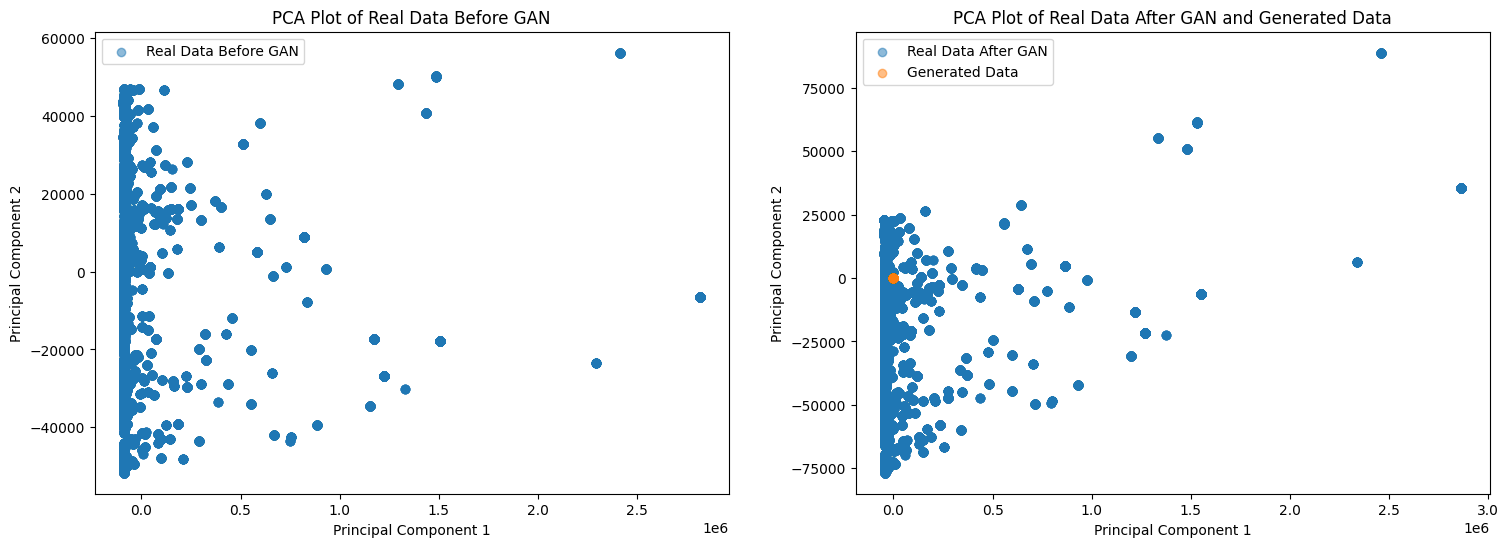

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on real data before GAN
pca_real_before = PCA(n_components=2)
pca_real_before_result = pca_real_before.fit_transform(real_data)

# Perform PCA on real data after GAN
pca_real_after = PCA(n_components=2)
pca_real_after_result = pca_real_after.fit_transform(combined_data)

# Perform PCA on generated data
pca_generated = PCA(n_components=2)
pca_generated_result = pca_generated.fit_transform(synthetic_data)

# Plot the PCA results
plt.figure(figsize=(18, 6))

# Plot real data before GAN
plt.subplot(1, 2, 1)
plt.scatter(pca_real_before_result[:, 0], pca_real_before_result[:, 1], label='Real Data Before GAN', alpha=0.5)
plt.title('PCA Plot of Real Data Before GAN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Plot real data after GAN and generated data
plt.subplot(1, 2, 2)
plt.scatter(pca_real_after_result[:, 0], pca_real_after_result[:, 1], label='Real Data After GAN', alpha=0.5)
plt.scatter(pca_generated_result[:, 0], pca_generated_result[:, 1], label='Generated Data', alpha=0.5)
plt.title('PCA Plot of Real Data After GAN and Generated Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.show()


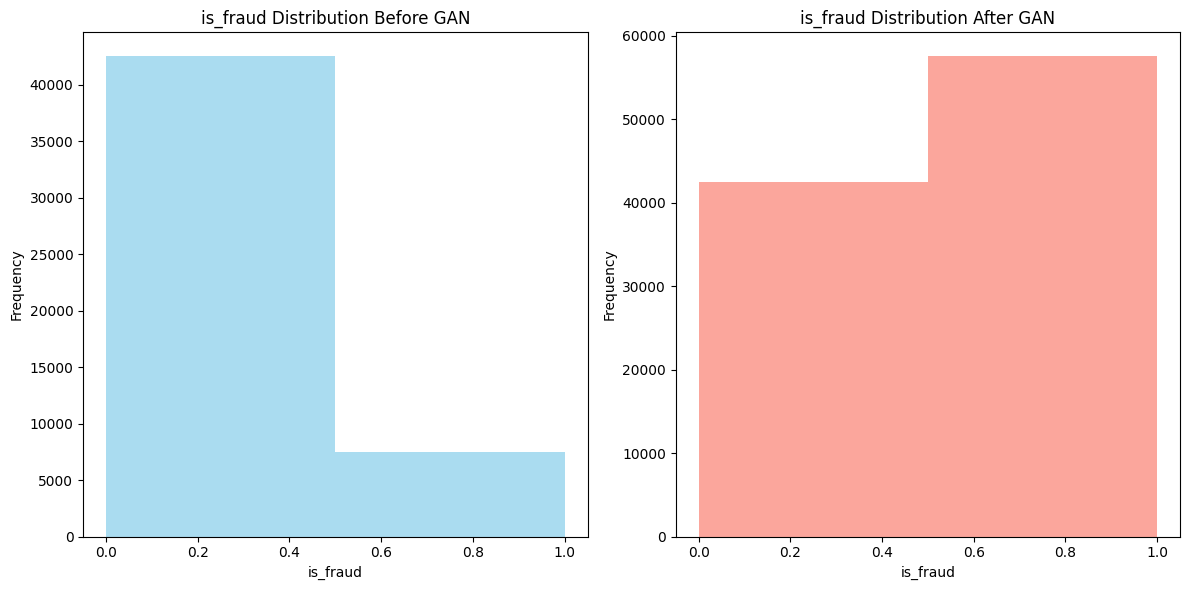

In [32]:
import matplotlib.pyplot as plt

# Plot is_fraud distribution before GAN
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(real_data['is_fraud'], bins=2, color='skyblue', alpha=0.7)
plt.title('is_fraud Distribution Before GAN')
plt.xlabel('is_fraud')
plt.ylabel('Frequency')

# Plot is_fraud distribution after GAN
plt.subplot(1, 2, 2)
plt.hist(combined_data['is_fraud'], bins=2, color='salmon', alpha=0.7)
plt.title('is_fraud Distribution After GAN')
plt.xlabel('is_fraud')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


##Predicting F1, Accuracy, Recall and Precision on GAN balanced data

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


X = combined_data.drop('is_fraud', axis=1)
y = combined_data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = LinearSVC(C=0.1, random_state=42)  # Linear kernel often faster
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.88585
Precision: 0.8860216861393628
Recall: 0.9191663760027904
F1 Score: 0.9022897496255082

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      8532
           1       0.89      0.92      0.90     11468

    accuracy                           0.89     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.89      0.89     20000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X = combined_data.drop('is_fraud', axis=1)
y = combined_data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_classifier = LinearSVC(C=0.1, random_state=42)
svm_classifier.fit(X_train, y_train)


y_pred = svm_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88585
Precision: 0.8860216861393628
Recall: 0.9191663760027904
F1 Score: 0.9022897496255082

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      8532
           1       0.89      0.92      0.90     11468

    accuracy                           0.89     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.89      0.89     20000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
